In [233]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from analysis_utils import *

In [234]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Setup

In [235]:
EXPERIMENT = 6

os.makedirs(f'stats/{EXPERIMENT}', exist_ok=True)
def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

data = get_data(EXPERIMENT)
pdf = data['participants'].set_index('pid').copy()
full_pdf = pdf.copy()
mdf = data['trials'].set_index('pid').copy()
mdf.trial_time /= 1000
mdf['clicked'] = mdf.n_clicks > 0

if EXPERIMENT == 3:
    pdf.query('completed_1', inplace=True)
else:
    pdf.query('completed', inplace=True)
    

if EXPERIMENT == 4:
    fb_namer = {
        (0, 0): 'none',
        (1, 0): 'info_only',
        (0, 1): 'reward_only',
        (1, 1): 'both'
    }
    pdf['feedback'] = pdf.apply(lambda row: fb_namer[row.information, row.reward], axis=1)
    mdf['information'] = pdf.information
    mdf['reward'] = pdf.reward
    fb_order = list(fb_namer.values())
elif EXPERIMENT == 6:
    pdf['test_env'] = pdf.pop('constantTest').apply(lambda x: 'constant' if x else 'increasing')
    mdf['test_env'] = pdf.test_env
    pdf['feedback'] = 'meta'
    mdf['feedback'] = 'meta'
else:
    fb_order = [fb for fb in ['none', 'action', 'meta'] if fb in set(pdf.feedback)]

## Demographics

In [236]:
pids = list(pdf.index.unique())
sdf = data['survey'].query('pid == @pids').copy()
if not isinstance(sdf.responses.iloc[0], dict):
    sdf = sdf.loc[~sdf.responses.isna()]
    sdf.responses = sdf.responses.apply(ast.literal_eval)

if EXPERIMENT == 3:
    demo = sdf.loc[sdf.responses.apply(len) == 3].set_index('pid').responses
    age = demo.apply(get('Q1'))
    gender = demo.apply(get('Q2'))
else:
    demo = sdf.loc[sdf.responses.apply(len) == 2].set_index('pid').responses
    age = demo.apply(get('Q0'))
    gender = demo.apply(get('Q1'))
    
gender = gender.str.lower()
age = age.apply(excepts(ValueError, int, lambda _: None))

write_tex('mean-age', f'{age.mean():.2f}')
write_tex('min-age', str(age.min()))
write_tex('max-age', str(age.max()))

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
write_tex("N-female", str(gender.value_counts()['female']))

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.test_env.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")

wrote "38.46" to "stats/6/mean-age.tex"
wrote "18" to "stats/6/min-age.tex"
wrote "71" to "stats/6/max-age.tex"
wrote "40" to "stats/6/N-female.tex"
wrote "$90$" to "stats/6/N-total.tex"
wrote "$46$" to "stats/6/N-constant.tex"
wrote "$44$" to "stats/6/N-increasing.tex"


In [237]:
if EXPERIMENT == 3:
    dropped = pdf.query('not completed').feedback.value_counts()
    rate = dropped / pdf.feedback.value_counts()
    for fb in fb_order:
        write_tex(f'N-drop-{fb}', dropped[fb])
        write_tex(f'drop-rate-{fb}', f'${rate[fb]*100:.1f}\%$')
    write_tex('return-rate', f'${pdf.completed.mean()*100:.1f}\%$')
    write_tex('return-N', f'${pdf.completed.sum()}$')
    pdf.query('completed', inplace=True)
    
pd.Series(pdf.index).to_csv(f'pids/{EXPERIMENT}.csv', index=False, header=False)

In [238]:
completed = list(pdf.index)
mdf.reset_index(inplace=True)
mdf.query('pid == @completed', inplace=True)
mdf.set_index('pid', inplace=True)

# pdf.feedback = pd.Categorical(pdf.feedback, fb_order, ordered=True)    
# mdf['feedback'] = pdf.feedback
block_mean = mdf.groupby(['block', 'pid']).score.mean()
for b in ['training', 'test']:
    pdf[b] = block_mean[b]

In [239]:
small_leaves = {3,4,7,8,11,12}
transfer_leaves = {5, 6, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 27, 28, 29, 31, 32, 33}

def clicked_leaf_first(row):
    if not row.clicks:
        return False
    first = row.clicks[0]
    transfer =  EXPERIMENT in (2, 3) and row.block == "test"
    leaves = transfer_leaves if transfer else small_leaves
    return first in leaves

mdf['backward'] = mdf.apply(clicked_leaf_first, axis=1)

## Setup Plotting 

In [240]:
figure = Figures(path=f'figs/{EXPERIMENT}', formats=['pdf', 'png']).plot

sns.set_style('whitegrid')
blue, orange, green, _, purple = sns.color_palette('tab10')[:5]
gray = (0.5,)*3
red = (1, 0.3, 0.4)
yellow = (1, 0.9, 0.4)

palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
    'increasing': orange,
    'constant': green,
}

nice_names = {
    'meta': 'Metacognitive',
    'action': 'Action',
    'none': 'None',
    'feedback': 'Feedback',
    'info_only': 'Information\nOnly',
    'reward_only': 'Reward\nOnly',
    'both': 'Information &\nReinforcement',
    'score': 'Average Score',
    'backward': 'Proportion Planning Backward',
    'constant': 'Constant',
    'increasing': 'Increasing',
    'test_env': 'Test Environment',
}

def reformat_labels(ax=None):
    ax = ax or plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [nice_names.get(lab, lab) for lab in labels]
    ax.set_xticklabels(new_labels)
    
def reformat_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    print([nice_names.get(l, l).replace('\n', ' ') for l in labels])
    ax.legend(handles=handles, labels=[nice_names.get(l, l).replace('\n', ' ') 
                                       for l in labels])
    
def plot_block_changes():
    block_changes = mdf.loc[1].block.apply(Labeler()).diff().reset_index().query('block == 1').index
    for t in block_changes:
        plt.axvline(t-0.5, c='k', ls='--')

from datetime import datetime
# os.makedirs(f'stats/{EXPERIMENT}/', exist_ok=True)
def result_file(name, ext='tex'):
    file = f'stats/{EXPERIMENT}-{name}.{ext}'
#     with open(file, 'w+') as f:
#         timestamp = datetime.now().strftime('Created on %m/%d/%y at %H:%M:%S\n\n')
#         f.write(timestamp)
    return file

# Learning curves

['Test Environment', 'Increasing', 'Constant']
figs/6/learning_curve_score.pdf
figs/6/learning_curve_score.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

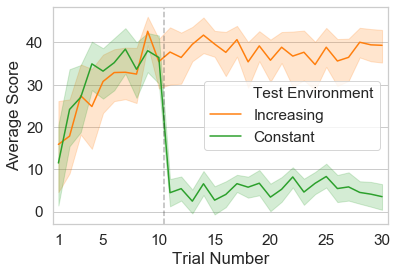

In [241]:
def learning_curve(var, drop_noclick=False):
    df = mdf.copy()
    if drop_noclick:
        df = df.query('clicked')
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='test_env', 
                 data=df, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    split = mdf.query('block == "training"').trial_index.max()
    plt.axvline(split+1.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()
    
figure(var='score')(learning_curve)

['Test Environment', 'Increasing', 'Constant']
figs/6/learning_curve_backward.pdf
figs/6/learning_curve_backward.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

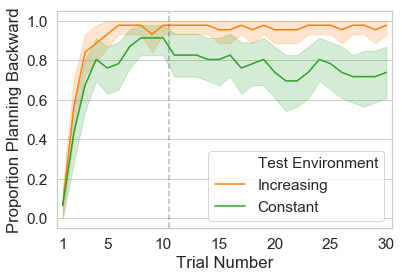

In [243]:
figure(var='backward')(learning_curve)

# Stats

## Score 

In [264]:
x = mdf.query('block == "test" and test_env == "constant"').groupby('backward').score.mean()
x

backward
False    5.322430
True     5.223796
Name: score, dtype: float64

In [257]:
rdf = mdf.query('block == "test" and test_env == "constant"').copy()
rdf = rdf[['score', 'backward', 'n_clicks']]
rdf.backward = rdf.backward.astype(int)

In [262]:
%%R -i rdf
summary(lm(score ~ backward, data=rdf))


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.322  -7.224   0.776   6.776  24.678 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.32243    0.70210   7.581  8.4e-14 ***
backward    -0.09863    0.80147  -0.123    0.902    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.27 on 918 degrees of freedom
Multiple R-squared:  1.65e-05,	Adjusted R-squared:  -0.001073 
F-statistic: 0.01515 on 1 and 918 DF,  p-value: 0.9021



In [258]:
%%R -i rdf
summary(lm(score ~ backward * n_clicks, data=rdf))


Call:
lm(formula = score ~ backward * n_clicks, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.642  -5.635   0.486   5.711  24.358 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        5.64193    1.01055   5.583 3.11e-08 ***
backward           3.19865    1.26929   2.520  0.01190 *  
n_clicks          -0.08178    0.18857  -0.434  0.66460    
backward:n_clicks -0.69387    0.23668  -2.932  0.00346 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.12 on 916 degrees of freedom
Multiple R-squared:  0.03131,	Adjusted R-squared:  0.02814 
F-statistic:  9.87 on 3 and 916 DF,  p-value: 2.074e-06



## Backward chisquare

In [245]:
# df = mdf.query('block == "test"')
assert mdf.trial_index.max() == 29
def write_backward_prop(drop_noclick):
    df = mdf.query('trial_index == 29')
    if drop_noclick:
        df = df.query('clicked')
    counts = df.groupby(['test_env', 'backward']).apply(len)
    stat, p = chisquare(counts['increasing'], counts['constant'])
    tex = rf'$\chi^2(1) = {int(stat)}, {pval(p)}$'
    name = 'backward-final-clicked' if drop_noclick else 'backward-final'
    write_tex(name, tex)

for x in False, True:
    write_backward_prop(x)

wrote "$\chi^2(1) = 12, p < .001$" to "stats/6/backward-final.tex"
wrote "$\chi^2(1) = 155, p < .001$" to "stats/6/backward-final-clicked.tex"


In [256]:
x = mdf.query('trial_index == 29').groupby('test_env').backward.mean()
for cond, prop in x.items():
    write_tex(f'proportion_strategy_change_trial30_{cond}', f"${prop*100:.1f}$\%")

wrote "$73.9$\%" to "stats/6/proportion_strategy_change_trial30_constant.tex"
wrote "$97.7$\%" to "stats/6/proportion_strategy_change_trial30_increasing.tex"


## Backward regression 

In [231]:
rdf = mdf.query('block == "test"').copy().reset_index()
# rdf = mdf.query('block == "test" and clicked').copy().reset_index()
rdf = rdf[['backward', 'trial_index', 'test_env', 'pid']]
rdf.backward = rdf.backward.astype(int)
rdf['switch'] = (rdf.pop('test_env') == 'constant').astype(int)
# rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [230]:
%%R -i rdf
require(ggplot2)
m = glm(backward ~ trial_index * switch, family=binomial, data=rdf)
# m = lm(backward ~ trial_index * switch, data=rdf)
summary(m)


Call:
glm(formula = backward ~ trial_index * switch, family = binomial, 
    data = rdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5433   0.0391   0.0961   0.5811   0.6998  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)          8.2574     2.4447   3.378 0.000731 ***
trial_index         -0.1802     0.1615  -1.116 0.264591    
switch              -6.3242     2.4519  -2.579 0.009899 ** 
trial_index:switch   0.1459     0.1623   0.899 0.368631    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 991.68  on 1702  degrees of freedom
Residual deviance: 791.85  on 1699  degrees of freedom
AIC: 799.85

Number of Fisher Scoring iterations: 9



In [224]:
from statsmodels.formula.api import glm
import statsmodels.api as sm
glm('backward ~ trial_index * switch', rdf, family=sm.families.Binomial()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               backward   No. Observations:                 1800
Model:                            GLM   Df Residuals:                     1796
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -620.25
Date:                Thu, 26 Dec 2019   Deviance:                       1240.5
Time:                        14:21:50   Pearson chi2:                 1.80e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.4472      0.373      9.238      0.000       2.716       4.179
trial_index           -0.0033      0.033     -0.100      0.920      -0.069       0.062
switch                -1.9363      0.405     -4.777      0.000      -2.731      -1.142
trial_index:switch    -0.0291      0.036     -0.808      0.419      -0.100       0.041
======================================================================================
"""

In [213]:
%%R -i rdf
require(lme4)
summary(glmer(backward ~ trial_index * switch + (1|pid), family=binomial, data=rdf))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: backward ~ trial_index * switch + (1 | pid)
   Data: rdf

     AIC      BIC   logLik deviance df.resid 
   284.4    311.6   -137.2    274.4     1698 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3380  0.0010  0.0026  0.0058  2.4692 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 114.4    10.69   
Number of obs: 1703, groups:  pid, 87

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        15.09533    3.64588   4.140 3.47e-05 ***
trial_index        -0.20130    0.17412  -1.156    0.248    
switch             -3.18171    3.70360  -0.859    0.390    
trial_index:switch  0.02732    0.17879   0.153    0.879    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) trl_nd switch
trial_index -0.711              
switc

In [180]:
rdf = rdf.groupby('pid').mean()

In [181]:
%%R -i rdf
summary(lm(backward ~ switch, data=rdf))


Call:
lm(formula = backward ~ switch, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82863  0.00233  0.00233  0.17137  0.17137 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.99767    0.03568   27.96  < 2e-16 ***
switch      -0.16905    0.05017   -3.37  0.00113 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.234 on 85 degrees of freedom
Multiple R-squared:  0.1178,	Adjusted R-squared:  0.1075 
F-statistic: 11.35 on 1 and 85 DF,  p-value: 0.001134



# Process

## Summary in test block

In [33]:
def report_ratio(df, key):
    name = key.replace('_', '-')
    X = df.groupby(['feedback', key]).apply(len)
    rate = 100 * df.groupby('feedback')[key].mean()

    for c in fb_order:
        r = rate[c]
        write_tex(f'{name}-{c}-percent', f"${r:.1f}$\%")


report_ratio(mdf.query('block == "test"').copy(), 'backward')

wrote "$6.8$\%" to "stats/5/backward-none-percent.tex"
wrote "$2.6$\%" to "stats/5/backward-meta-percent.tex"


## Mediation

In [19]:
rdf = mdf.query('block == "test"').copy().rename(columns={'information': 'info'})
# rdf['feedback'] = (rdf.feedback != 'none').astype(int)

if EXPERIMENT == 4:
    factors = ['info', 'reward']
    for c in factors:
        rdf[c] = rdf[c].astype(float)
else:
    factors = ['action', 'meta']
    fb = rdf.pop('feedback')
    for c in factors:
        rdf[c] = (fb == c).astype(int)

rdf['clicked'] = rdf.clicked.astype(int)
rdf = rdf[[*factors, 'backward', 'clicked', 'n_clicks', 'score', 'trial_index', 'stim_i']].reset_index()
rdf.backward.fillna(0, inplace=True)
# rdf.trial_index = rdf.trial_index.astype(float)
# rdf.query('action == 0', inplace=True)
rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [20]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.959  -3.473   0.393   3.260  34.909 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.691      1.020    7.54 3.19e-13 ***
backward      31.716      1.182   26.82  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.335 on 399 degrees of freedom
Multiple R-squared:  0.6433,	Adjusted R-squared:  0.6424 
F-statistic: 719.4 on 1 and 399 DF,  p-value: < 2.2e-16



In [21]:
score = dict(score.items())
df = score['df'][1]
est, std, t, p = score['coefficients'][1]
write_tex(f'score-backward', f'${est:.3f}$')
write_tex(f'score-backward-test', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

wrote "$31.716$" to "stats/4/score-backward.tex"
wrote "$t(399) = 26.822$, $p < .001$" to "stats/4/score-backward-test.tex"


In [22]:
%%R -i rdf -i EXPERIMENT -o back -o med_out
library(mediation)

if (EXPERIMENT == 1) {
    back_fit = lm(backward ~ action + meta, data=rdf)
    score_fit = lm(score ~ backward + action + meta, data=rdf)
} else {
    back_fit = lm(backward ~ meta, data=rdf)
    score_fit = lm(score ~ backward + meta, data=rdf)
}
med_out = mediate(back_fit, score_fit, treat="meta", mediator="backward")
back = summary(back_fit)
summary(med_out)

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.4.7


R[write to console]: Error in eval(predvars, data, env) : object 'meta' not found
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval




Error in eval(predvars, data, env) : object 'meta' not found
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval


In [23]:
back = dict(back.items())
df = back['df'][1]
for i, name in enumerate(fb_order[1:], start=1):
    est, std, t, p = back['coefficients'][i]
    write_tex(f'backward-lm-{name}', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

NameError: name 'back' is not defined

In [ ]:
names = {
    'acme': 'd0',
    'ade': 'z0',
    'total': 'tau',
    'prop': 'n0',
}
med = dict(med_out.items())

for k, v in names.items():
    est = med[v + ('.coef' if v == 'tau' else '')][0]
    lo, hi = med[v+'.ci']
    p = med[v+'.p'][0]
    write_tex(f'mediation-{k}', f'{est:.3f}')
    write_tex(f'mediation-{k}-ci', f'95\% CI: [{lo:.3f}, {hi:.3f}], ${pval(p)}$')

In [ ]:
print("Success!")